In [1]:
# install modules
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

  Attempting uninstall: ipython
    Found existing installation: ipython 9.4.0
    Uninstalling ipython-9.4.0:
      Successfully uninstalled ipython-9.4.0


In [2]:
import sys

import numpy as np
import pandas as pd
import pyquadkey2.quadkey as qk
from geopy import distance

import folium
from IPython.display import HTML

from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Functions

## get_bbox_for_qkey

In [3]:
def get_bbox_for_qkey(qkey):
    
    result = pd.NA

    qkey = qk.QuadKey(qkey)

    # get bb for qkey
    bb_lb = qkey.to_geo(qk.TileAnchor.ANCHOR_SW)
    bb_rt = qkey.to_geo(qk.TileAnchor.ANCHOR_NE)

    result = bb_lb,bb_rt
    
    return result

## get_bbox_sides

In [4]:
def get_bbox_sides(bbox):

    result = pd.NA

    (min_lat,min_lon),(max_lat,max_lon) = bbox[0],bbox[1]
    
    # bbox side
    dist_lat = distance.distance((min_lat,min_lon),(max_lat,min_lon)).km
    dist_lon = distance.distance((min_lat,min_lon),(min_lat,max_lon)).km
    
    result = round(dist_lat,2),round(dist_lon,2)

    return result

## plot_bboxes

In [5]:
def plot_bboxes(bboxes,zoom=15,center=True,size=600,custom_loc=[]):
  
    # map center
    map_min_lat = min(bb[0][0] for bb in bboxes)
    map_min_lon = min(bb[0][1] for bb in bboxes)
    map_max_lat = max(bb[1][0] for bb in bboxes)
    map_max_lon = max(bb[1][1] for bb in bboxes)
    map_center_lat = (map_min_lat + map_max_lat)/2
    map_center_lon = (map_min_lon + map_max_lon)/2

    # init map        
    m = folium.Map(location=(map_center_lat,map_center_lon), zoom_start=zoom, width=size, height=size)

    for bbox in bboxes:

        bb_lb,bb_rt = bbox
        points=[bb_lb, (bb_rt[0], bb_lb[1]), bb_rt, (bb_lb[0], bb_rt[1])]
        poly = folium.Polygon(locations=points,color='red',fill=True,fill_color='red')
        poly.add_to(m)  

    # plot center loc
    if center:
        poly = folium.Marker([map_center_lat,map_center_lon],
                             icon=folium.Icon(color='blue'),popup='Crime')
        poly.add_to(m)    

    # plot custom loc    
    if len(custom_loc) == 2:
        marker = folium.Marker([custom_loc[0],custom_loc[1]],
                               icon=folium.Icon(color='red'),popup='Trace of evidence')
        marker.add_to(m)

    return m

## frame_info

In [6]:
def frame_info(frame,sample=False,n=10,width=50,columns=50):

    size = len(frame)

    display(frame.info(memory_usage='deep'))

    if sample:
        frame = frame.sample(min(n,size))

    with pd.option_context('display.min_rows', n, 'display.max_rows', n,
                           'display.max_columns', columns,'display.max_colwidth', width):
        display(frame)

    return

## sort_data

In [7]:
def sort_data(by,what):
    
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), preprocessor=None, token_pattern=None)

    documents = tuple([by]) + what
    
    tfidf_matrix = vectorizer.fit_transform(documents)
    
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
   
    sorted_index = []
    sorted_scores = []

    # first row, drop self-similar
    docs_score = cosine_sim[0][1:]

    if not np.all(docs_score == 0.0): 

        # order by most similar        
        sorted_index = np.argsort(docs_score)[::-1]
        sorted_score = docs_score[sorted_index]

        sorted_index = sorted_index.tolist()
        sorted_score = sorted_score.tolist()

    return sorted_index,sorted_score

# Reasoning

## City

In [8]:
MAP_DIR = 'result-forensic-maps'

qkey = '0320101101322222'
bbox = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox)[0]
side = round(side*2)/2
print(side)

m = plot_bboxes(bboxes=[bbox],center=True,zoom=17,size=600)
m.save(f'{MAP_DIR}/map-problem-crime-scene-city-{side}.html')
display(HTML(open(f'{MAP_DIR}/map-problem-crime-scene-city-{side}.html').read()))

0.5


In [9]:
# 500
qkey = '0320101101322222'
bbox_500 = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox_500)[0]
side = round(side*2)/2
print(side)

# 1000
qkey = '032010110132222'
bbox_1000 = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox_1000)[0]
side = round(side*2)/2
print(side)

# 2000
qkey = '03201011013222'
bbox_2000 = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox_2000)[0]
side = round(side*2)/2
print(side)

m = plot_bboxes(bboxes=[bbox_500,bbox_1000,bbox_2000],zoom=15,size=600,center=False)
m.save(f'{MAP_DIR}/map-problem-crime-scene-city-{side}.html')
display(HTML(open(f'{MAP_DIR}/map-problem-crime-scene-city-{side}.html').read()))

0.5
1.0
2.0


## Country

In [10]:
qkey = '0320231020030'
bbox = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox)[0]
side = round(side*2)/2
print(side)

m = plot_bboxes(bboxes=[bbox],zoom=14,size=600)
m.save(f'{MAP_DIR}/map-problem-crime-scene-country-{side}.html')
display(HTML(open(f'{MAP_DIR}/map-problem-crime-scene-country-{side}.html').read()))

4.5


In [11]:
qkey = '032023011013'
bbox = get_bbox_for_qkey(qkey)
side = get_bbox_sides(bbox=bbox)[0]
side = round(side*2)/2
print(side)

m = plot_bboxes(bboxes=[bbox],zoom=13,size=600)
m.save(f'{MAP_DIR}/map-problem-crime-scene-country-{side}.html')
display(HTML(open(f'{MAP_DIR}/map-problem-crime-scene-country-{side}.html').read()))

8.5


# Datasets

## Crime scene data

In [12]:
crime_data = pd.read_parquet(f'dataset-crime-scene/dataset-crime-scene.parquet')

frame_info(crime_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   city        1000 non-null   category
 1   bbox        1000 non-null   object  
 2   bbox_text   1000 non-null   string  
 3   trace       1000 non-null   string  
 4   trace_text  1000 non-null   string  
dtypes: category(1), object(1), string(3)
memory usage: 4.7 MB


None

,city,bbox,bbox_text,trace,trace_text
0,chicago,"[[41.959490098924, -87.687377929687], [41.9635...",4518 leavitt 8262 cobblestonechicago goku miku...,https://oakleypsychologicalassociates.com/,oakley psychological associates home services ...
1,chicago,"[[41.836827860727, -87.637939453125], [41.8409...",states 407639 american danforth dragonbowl 138...,https://www.francoschicago.com/,authentic italian franco s ristorante chicago ...
2,chicago,"[[42.020732852644, -87.769775390625], [42.0248...",states linder 5701 646 linens expressway mulfo...,https://shareourfuture.org/tour/,interactive virtual tour capital campaign arie...
3,chicago,"[[41.996242821785, -87.71484375], [42.00032514...",states spaulding kedzie 6426 5828 currency 640...,https://www.cityfreshmarket.com/,city fresh market european specialties and eve...
4,chicago,"[[41.943148747326, -87.709350585937], [41.9472...",3407 states 3451 kedzie parachute 3515 bikeway...,https://pumpingstationone.org/,pumping station one chicago s oldest and large...
...,...,...,...,...,...
995,phoenix,"[[33.605469612271, -112.120971679687], [33.610...",mani states maricopa 13610 9878 corporate 3420...,https://spatasticbluenails.com/,spa tastic blue nails 0 skip to content spa ta...
996,phoenix,"[[33.348884792201, -111.967163085937], [33.353...",states 359 correction todd 3041 33.3 1236 mari...,https://www.extendasuites.com/extend-a-suites-...,comfortable hotel in tempe az extend a suites ...
997,phoenix,"[[33.468107955278, -112.066040039062], [33.472...",states pastry 389 nami husbandandwifelawteam z...,https://www.urbanwellnessphx.com,urban wellness phoenix naturopath yoga colonic...
998,phoenix,"[[33.536816067733, -112.181396484375], [33.541...",bonbu 787 maricopa Shang sahnghong pete jiaohu...,https://enlaceaz.com,enlace tax in glendale az 85301 enlace 623 217...


In [13]:
crime_data.groupby('city',observed=True).city.apply(len)

city
chicago          200
houston          200
los angeles      200
new york city    200
phoenix          200
Name: city, dtype: int64

In [14]:
# map of city crime scene areas

city = set(crime_data.city)

for item in city:
    print(item)
    item_data = crime_data.loc[crime_data.city == item]
    m = plot_bboxes(bboxes=item_data.bbox,zoom=10,size=600,center=False)
    item = item.replace(" ", "-")
    
    m.save(f'{MAP_DIR}/map-crime-scenes-{item}.html')
    display(HTML(open(f'{MAP_DIR}/map-crime-scenes-{item}.html').read()))
    print()

new york city



houston



phoenix



chicago



los angeles


In [15]:
# sample city crime scene and trace of evidence
for item in city:
    print(item)
    item_data = crime_data.loc[crime_data.city == item].sample(1,random_state=0)
    print(item_data.trace.item())
    item = item.replace(" ", "-")
    m = plot_bboxes(bboxes=item_data.bbox,zoom=17,size=600)
    
    m.save(f'{MAP_DIR}/map-sample-crime-scene-{item}.html')
    display(HTML(open(f'{MAP_DIR}/map-sample-crime-scene-{item}.html').read()))
    print()

new york city
https://maceavenuemedical.com



houston
https://typhoontexas.com/houston



phoenix
https://www.tideson59th.com/



chicago
https://ampbusinessvaluations.com



los angeles
https://www.hangsteady.com/


## Forensic data

In [16]:
forensic_data = pd.read_parquet(f'dataset-forensic-web/dataset-forensic-web.parquet')

frame_info(forensic_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     10000 non-null  string
 1   text    10000 non-null  string
dtypes: string(2)
memory usage: 50.6 MB


None

,url,text
0,https://lms.zohospark.com/,welcome to zoho s self learning platform log i...
1,https://www.progressivecsllc.com/group/book-cl...,welcome to the group you can connect with othe...
2,https://www.fiorucci.com/uk/ear-cuff-blue/PF24...,fiorucci official online store ear cuff blue f...
3,https://clubsandwich.ticketleap.com/bjhickman/...,magician bj hickman at club sandwich tickets i...
4,https://intentionalfamilylife.com/tag/winter/p...,winter archives page 3 of 3 intentional family...
...,...,...
9995,https://www.jfree.org/forum/search.php?search_...,www jfree org unanswered topics www jfree org ...
9996,https://www.aan.com/MSA/Public/Events/Details/...,2023 annual meeting chair massage american aca...
9997,https://gaymotors.com/v/gay-sex-slave-punished...,gay sex slave punished by his master gayxo com...
9998,https://marioncvb.com/blog/51883-2/,our stories marion county cvb marion county cv...


# Forensic analysis

## Processing

In [17]:
forensic_text = tuple(forensic_data.text.tolist())

In [18]:
%%time
crime_data[['forensic_index','forensic_score']] = crime_data.progress_apply(lambda r: sort_data(
    by=r.bbox_text, what=forensic_text+(r.trace_text,)),axis=1,result_type = 'expand')

frame_info(crime_data)

100%|█████████████████████████████████████████████████████████| 1000/1000 [1:34:49<00:00,  5.69s/it]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   city            1000 non-null   category
 1   bbox            1000 non-null   object  
 2   bbox_text       1000 non-null   string  
 3   trace           1000 non-null   string  
 4   trace_text      1000 non-null   string  
 5   forensic_index  1000 non-null   object  
 6   forensic_score  1000 non-null   object  
dtypes: category(1), object(3), string(3)
memory usage: 157.4 MB


None

,city,bbox,bbox_text,trace,trace_text,forensic_index,forensic_score
0,chicago,"[[41.959490098924, -87.687377929687], [41.9635...",4518 leavitt 8262 cobblestonechicago goku miku...,https://oakleypsychologicalassociates.com/,oakley psychological associates home services ...,"[4003, 6575, 2168, 4479, 4683, 7378, 7454, 294...","[0.06322591046811418, 0.057458024674410926, 0...."
1,chicago,"[[41.836827860727, -87.637939453125], [41.8409...",states 407639 american danforth dragonbowl 138...,https://www.francoschicago.com/,authentic italian franco s ristorante chicago ...,"[10000, 6575, 4003, 4683, 7454, 265, 2168, 803...","[0.14268422571367953, 0.09793503318882087, 0.0..."
2,chicago,"[[42.020732852644, -87.769775390625], [42.0248...",states linder 5701 646 linens expressway mulfo...,https://shareourfuture.org/tour/,interactive virtual tour capital campaign arie...,"[6575, 4842, 4003, 9266, 7454, 10000, 1528, 19...","[0.0922371035358035, 0.08739117409478624, 0.07..."
3,chicago,"[[41.996242821785, -87.71484375], [42.00032514...",states spaulding kedzie 6426 5828 currency 640...,https://www.cityfreshmarket.com/,city fresh market european specialties and eve...,"[6575, 4003, 4683, 6828, 8253, 7454, 1528, 724...","[0.09286373496138763, 0.07976311591911592, 0.0..."
4,chicago,"[[41.943148747326, -87.709350585937], [41.9472...",3407 states 3451 kedzie parachute 3515 bikeway...,https://pumpingstationone.org/,pumping station one chicago s oldest and large...,"[10000, 6575, 4003, 9624, 4683, 9581, 8253, 74...","[0.08520335627498779, 0.07370786412999956, 0.0..."
...,...,...,...,...,...,...,...
995,phoenix,"[[33.605469612271, -112.120971679687], [33.610...",mani states maricopa 13610 9878 corporate 3420...,https://spatasticbluenails.com/,spa tastic blue nails 0 skip to content spa ta...,"[10000, 6744, 7454, 1528, 4318, 7375, 7233, 24...","[0.1268725761348461, 0.07371251993157432, 0.07..."
996,phoenix,"[[33.348884792201, -111.967163085937], [33.353...",states 359 correction todd 3041 33.3 1236 mari...,https://www.extendasuites.com/extend-a-suites-...,comfortable hotel in tempe az extend a suites ...,"[10000, 5246, 7454, 1528, 761, 8915, 8023, 335...","[0.07889399104107317, 0.07677789220833425, 0.0..."
997,phoenix,"[[33.468107955278, -112.066040039062], [33.472...",states pastry 389 nami husbandandwifelawteam z...,https://www.urbanwellnessphx.com,urban wellness phoenix naturopath yoga colonic...,"[5751, 10000, 2188, 4192, 5265, 8692, 6733, 74...","[0.10419539589772878, 0.07713929720614503, 0.0..."
998,phoenix,"[[33.536816067733, -112.181396484375], [33.541...",bonbu 787 maricopa Shang sahnghong pete jiaohu...,https://enlaceaz.com,enlace tax in glendale az 85301 enlace 623 217...,"[10000, 7874, 1194, 1885, 927, 2886, 8343, 297...","[0.11120394344062544, 0.04818135296544333, 0.0..."


CPU times: user 1h 30min 8s, sys: 4min 29s, total: 1h 34min 38s
Wall time: 1h 34min 49s


In [19]:
# position of trace evidence in rakned forensic data
crime_data['trace_pos'] = crime_data.forensic_index.apply(lambda x: x.index(len(forensic_data))+1)
frame_info(crime_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   city            1000 non-null   category
 1   bbox            1000 non-null   object  
 2   bbox_text       1000 non-null   string  
 3   trace           1000 non-null   string  
 4   trace_text      1000 non-null   string  
 5   forensic_index  1000 non-null   object  
 6   forensic_score  1000 non-null   object  
 7   trace_pos       1000 non-null   int64   
dtypes: category(1), int64(1), object(3), string(3)
memory usage: 157.4 MB


None

,city,bbox,bbox_text,trace,trace_text,forensic_index,forensic_score,trace_pos
0,chicago,"[[41.959490098924, -87.687377929687], [41.9635...",4518 leavitt 8262 cobblestonechicago goku miku...,https://oakleypsychologicalassociates.com/,oakley psychological associates home services ...,"[4003, 6575, 2168, 4479, 4683, 7378, 7454, 294...","[0.06322591046811418, 0.057458024674410926, 0....",31
1,chicago,"[[41.836827860727, -87.637939453125], [41.8409...",states 407639 american danforth dragonbowl 138...,https://www.francoschicago.com/,authentic italian franco s ristorante chicago ...,"[10000, 6575, 4003, 4683, 7454, 265, 2168, 803...","[0.14268422571367953, 0.09793503318882087, 0.0...",1
2,chicago,"[[42.020732852644, -87.769775390625], [42.0248...",states linder 5701 646 linens expressway mulfo...,https://shareourfuture.org/tour/,interactive virtual tour capital campaign arie...,"[6575, 4842, 4003, 9266, 7454, 10000, 1528, 19...","[0.0922371035358035, 0.08739117409478624, 0.07...",6
3,chicago,"[[41.996242821785, -87.71484375], [42.00032514...",states spaulding kedzie 6426 5828 currency 640...,https://www.cityfreshmarket.com/,city fresh market european specialties and eve...,"[6575, 4003, 4683, 6828, 8253, 7454, 1528, 724...","[0.09286373496138763, 0.07976311591911592, 0.0...",92
4,chicago,"[[41.943148747326, -87.709350585937], [41.9472...",3407 states 3451 kedzie parachute 3515 bikeway...,https://pumpingstationone.org/,pumping station one chicago s oldest and large...,"[10000, 6575, 4003, 9624, 4683, 9581, 8253, 74...","[0.08520335627498779, 0.07370786412999956, 0.0...",1
...,...,...,...,...,...,...,...,...
995,phoenix,"[[33.605469612271, -112.120971679687], [33.610...",mani states maricopa 13610 9878 corporate 3420...,https://spatasticbluenails.com/,spa tastic blue nails 0 skip to content spa ta...,"[10000, 6744, 7454, 1528, 4318, 7375, 7233, 24...","[0.1268725761348461, 0.07371251993157432, 0.07...",1
996,phoenix,"[[33.348884792201, -111.967163085937], [33.353...",states 359 correction todd 3041 33.3 1236 mari...,https://www.extendasuites.com/extend-a-suites-...,comfortable hotel in tempe az extend a suites ...,"[10000, 5246, 7454, 1528, 761, 8915, 8023, 335...","[0.07889399104107317, 0.07677789220833425, 0.0...",1
997,phoenix,"[[33.468107955278, -112.066040039062], [33.472...",states pastry 389 nami husbandandwifelawteam z...,https://www.urbanwellnessphx.com,urban wellness phoenix naturopath yoga colonic...,"[5751, 10000, 2188, 4192, 5265, 8692, 6733, 74...","[0.10419539589772878, 0.07713929720614503, 0.0...",2
998,phoenix,"[[33.536816067733, -112.181396484375], [33.541...",bonbu 787 maricopa Shang sahnghong pete jiaohu...,https://enlaceaz.com,enlace tax in glendale az 85301 enlace 623 217...,"[10000, 7874, 1194, 1885, 927, 2886, 8343, 297...","[0.11120394344062544, 0.04818135296544333, 0.0...",1


## Results

In [20]:
# separated forensic data bins of 100URLs
bins = np.arange(0, 10000 + 100, 100)
bins

array([    0,   100,   200,   300,   400,   500,   600,   700,   800,
         900,  1000,  1100,  1200,  1300,  1400,  1500,  1600,  1700,
        1800,  1900,  2000,  2100,  2200,  2300,  2400,  2500,  2600,
        2700,  2800,  2900,  3000,  3100,  3200,  3300,  3400,  3500,
        3600,  3700,  3800,  3900,  4000,  4100,  4200,  4300,  4400,
        4500,  4600,  4700,  4800,  4900,  5000,  5100,  5200,  5300,
        5400,  5500,  5600,  5700,  5800,  5900,  6000,  6100,  6200,
        6300,  6400,  6500,  6600,  6700,  6800,  6900,  7000,  7100,
        7200,  7300,  7400,  7500,  7600,  7700,  7800,  7900,  8000,
        8100,  8200,  8300,  8400,  8500,  8600,  8700,  8800,  8900,
        9000,  9100,  9200,  9300,  9400,  9500,  9600,  9700,  9800,
        9900, 10000])

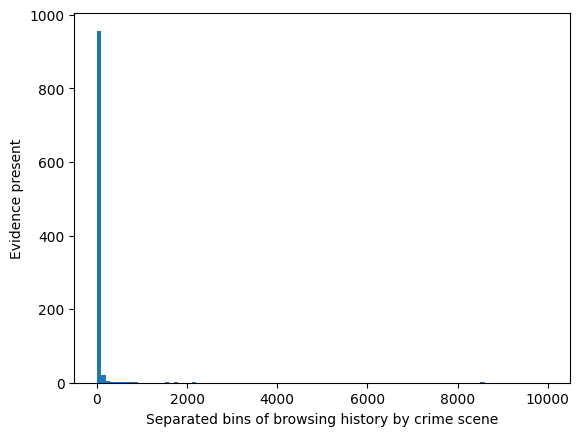

In [21]:
ax = crime_data.trace_pos.hist(bins=bins,grid=False)
ax.set_xlabel('Separated bins of browsing history by crime scene')
ax.set_ylabel('Evidence present')
plt.savefig(f'result-forensic-performance/fig-forensic-performance-hist.pdf',bbox_inches='tight',pad_inches=0)
plt.show()

!all
Trace discovery accuracy stat
count    1000.000000
mean       33.497000
std       297.688045
min         1.000000
50%         1.000000
75%         6.000000
95%        92.100000
max      8574.000000
Name: trace_pos, dtype: float64

Separeted web data and trace discovery accuracy
100 96.0
150 97.0
200 98.0

!new york city
Trace discovery accuracy stat
count     200.000000
mean       55.975000
std       241.620314
min         1.000000
50%         2.000000
75%        14.000000
95%       121.500000
max      2165.000000
Name: trace_pos, dtype: float64

Separeted web data and trace discovery accuracy
100 94.0
150 95.0
200 96.0

!houston
Trace discovery accuracy stat
count    200.000000
mean      13.555000
std       39.398581
min        1.000000
50%        1.000000
75%        4.250000
95%       73.350000
max      296.000000
Name: trace_pos, dtype: float64

Separeted web data and trace discovery accuracy
100 96.0
150 96.0
200 99.0

!phoenix
Trace discovery accuracy stat
count    200.000000

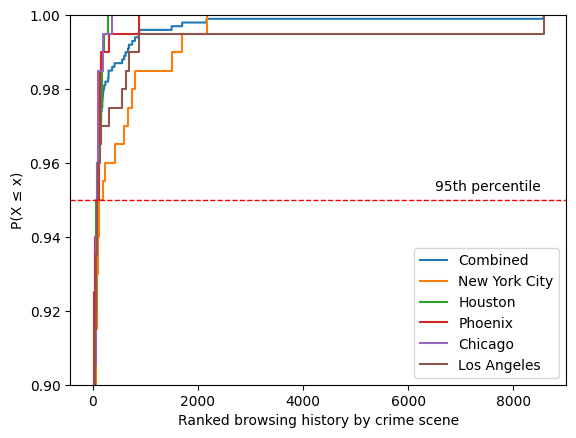

In [22]:
# detailed results and results per city
percentiles = [100,150,200]

print('!all')
ax = sns.ecdfplot(crime_data.trace_pos,label='Combined')
print('Trace discovery accuracy stat')
print(crime_data.trace_pos.describe(percentiles=[.75,.95]))
print('\nSepareted web data and trace discovery accuracy')
for item in percentiles:
    percentile = stats.percentileofscore(crime_data.trace_pos, item, kind='rank')
    print(item,percentile.round())

for city_item in city:
    print()
    print(f'!{city_item}')
    item_data = crime_data.loc[crime_data.city == city_item]
    sns.ecdfplot(item_data.trace_pos,label=city_item.title())

    print('Trace discovery accuracy stat')
    print(item_data.trace_pos.describe([.75,.95]))

    print('\nSepareted web data and trace discovery accuracy')
    for item in percentiles:
        percentile = stats.percentileofscore(item_data.trace_pos, item, kind='rank')
        print(item,percentile.round())

ax.set_xlabel('Ranked browsing history by crime scene')
ax.set_ylabel('P(X ≤ x)')
ax.set_ylim(bottom=0.9)
ax.axhline(y=0.95, color='r', linestyle='--', linewidth=1)
ax.text(
    x=6500,
    y=0.9525,
    s='95th percentile',
)
ax.legend()
plt.savefig(f'result-forensic-performance/fig-forensic-performance-ecdf.pdf',bbox_inches='tight',pad_inches=0)
print()
plt.show()

## Samples

In [23]:
# garage in Houston

sample = crime_data.loc[crime_data.trace == 'https://galaxyautomotive.biz/']
sample.pop('forensic_index')
sample.pop('forensic_score')
sample.to_dict()

{'city': {222: 'houston'},
 'bbox': {222: array([array([ 29.95493455, -95.58654785]),
         array([ 29.95969381, -95.58105469])], dtype=object)},
 'bbox_text': {222: 'states tx 77070 12620 thornwell creekstone millridge mccracken harris -95.6 -95.5 us united saathoff creekline ocean galaxy city county 12509 boulevard 30.0 texas 29.9 banchester canmere'},
 'trace': {222: 'https://galaxyautomotive.biz/'},
 'trace_text': {222: 'auto repair houston tx galaxy automotive 12509 jones rd houston tx 77070 832 912 7707 pages navigation menu home services coupons appointments testimonials contact us home services coupons appointments testimonials contact us prev next 1 2 3 4 welcome to galaxy automotive posted by m1scrm posted on june 19 2014 uncategorized comments off on welcome to galaxy automotive we are working hard to be your number one choice in automotive repair and maintenance our team is dedicated to providing you and your vehicle with professional service and exceptional customer car

In [24]:
# laundromat in Chicago

sample = crime_data.loc[crime_data.trace == 'https://spincyclelaundrychicago.com/']
sample.pop('forensic_index')
sample.pop('forensic_score')
sample.to_dict()

{'city': {59: 'chicago'},
 'bbox': {59: array([array([ 41.99216023, -87.69287109]),
         array([ 41.99624282, -87.68737793])], dtype=object)},
 'bbox_text': {59: 'states 606593783 7885 glenlake 6240 2862 306021 33939 6200 41.9 granville cta 13454 korczak divvy us 0094 lyft 38826 chicago united western 6155 janusz 961 7921 avenue county 843673 spincycle 240939 60659 6156 -87.6 -87.7 g2s10000000000x 6210 6236 6108 north cook illinois 6254 7354 ridge 116624 jefferson il wtextndsource township 42.0 west 60645 6510'},
 'trace': {59: 'https://spincyclelaundrychicago.com/'},
 'trace_text': {59: 'premier laundromat laundry services chicago il spincycle laundromat spincycle laundry ph 773 961 7354 hours open 6am to 10pm every day 6200 n western ave chicago il 60659 schedule a pickup menu pickup delivery wash fold commercial laundry self service laundry service areas laundry service in rogers park chicago laundry service in west rogers park chicago laundry service in andersonville chicago la